In [2]:
import pandas as pd 
import numpy as np        
import matplotlib.pyplot as plt   
from datetime import datetime   
from pandas import Series       
%matplotlib inline 
import warnings                  
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error 
from math import sqrt 

data = pd.read_excel(r"C:\Users\Zahraa\Downloads\Dataset 1.xlsx")

In [3]:
data=data.drop(columns=['Unnamed: 12','Unnamed: 13','Unnamed: 14','Stockout','Profit','Discount','Sales'])

In [4]:
data['Cal Date'] = pd.to_datetime(data['Cal Date'],format='%d-%m-%Y %H:%M') 
data['Cal Date'] = (data['Cal Date'] + pd.Timedelta(days=1)).apply(lambda x: x - pd.offsets.Week(weekday=6))
data = data.sort_values('Quantity')
data

,Week,Cal Date,Year,Month,Store Number,Product Name,Brand,Quantity
22185,2022-08-20,2022-08-14,2022,8,453,Product D,Brand Z,1.0
4475,2023-12-23,2023-12-17,2023,12,177,Product L,Brand Z,1.0
4479,2023-12-23,2023-12-17,2023,12,128,Product F,Brand X,1.0
4480,2023-12-23,2023-12-17,2023,12,587,Product L,Brand Z,1.0
4485,2023-12-23,2023-12-17,2023,12,540,Product H,Brand X,1.0
...,...,...,...,...,...,...,...,...
22174,2022-08-27,2022-08-21,2022,8,506,Product D,Brand Z,NaN
22175,2022-08-27,2022-08-21,2022,8,509,Product G,Brand X,NaN
22176,2022-08-27,2022-08-21,2022,8,526,Product D,Brand Z,NaN
22183,2022-08-20,2022-08-14,2022,8,98,Product D,Brand Z,NaN


In [5]:
data.dropna(subset=['Quantity'], inplace=True)

In [6]:
data_grouped = data.groupby(['Product Name', 'Cal Date', 'Brand']).agg(
    total_quantity=('Quantity', 'sum'),  # Total quantity
    number_of_stores=('Store Number','count')
).reset_index()

In [7]:
#data_grouped.drop(subset=['total_quantity'], inplace=True)
data_grouped = data_grouped.loc[data_grouped['total_quantity'] != 0]

In [8]:
data_grouped.reset_index(inplace=True)
data_grouped.rename(columns={'index': 'unique_id'}, inplace=True)

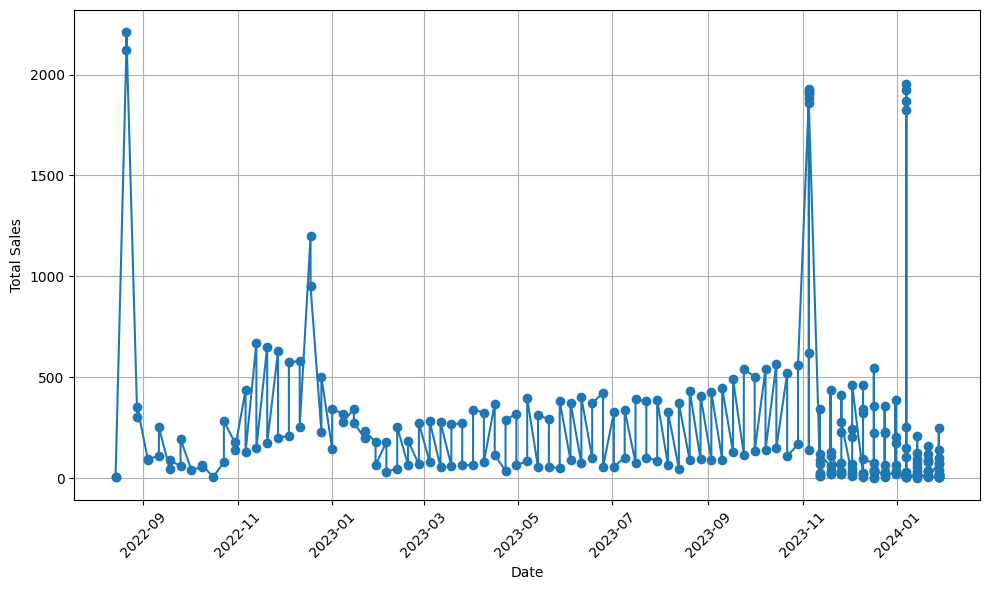

In [11]:
plt.figure(figsize=(10, 6))
plt.plot(data_grouped['Cal Date'], data_grouped['total_quantity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

In [12]:
data_grouped = data_grouped.sort_values('Cal Date')
data_grouped

,unique_id,Product Name,Cal Date,Brand,total_quantity,number_of_stores
92,92,Product G,2022-08-14,Brand X,6.0,1
4,4,Product D,2022-08-14,Brand Z,5.0,2
93,93,Product G,2022-08-21,Brand X,2124.0,573
5,5,Product D,2022-08-21,Brand Z,2210.0,570
94,94,Product G,2022-08-28,Brand X,303.0,76
...,...,...,...,...,...,...
254,254,Product W,2024-01-28,Brand Z,5.0,2
163,163,Product Q,2024-01-28,Brand Z,74.0,23
248,248,Product T,2024-01-28,Brand X,13.0,3
134,134,Product K,2024-01-28,Brand X,5.0,2


In [13]:
data_grouped = data_grouped[data_grouped['total_quantity'] <= 1500]

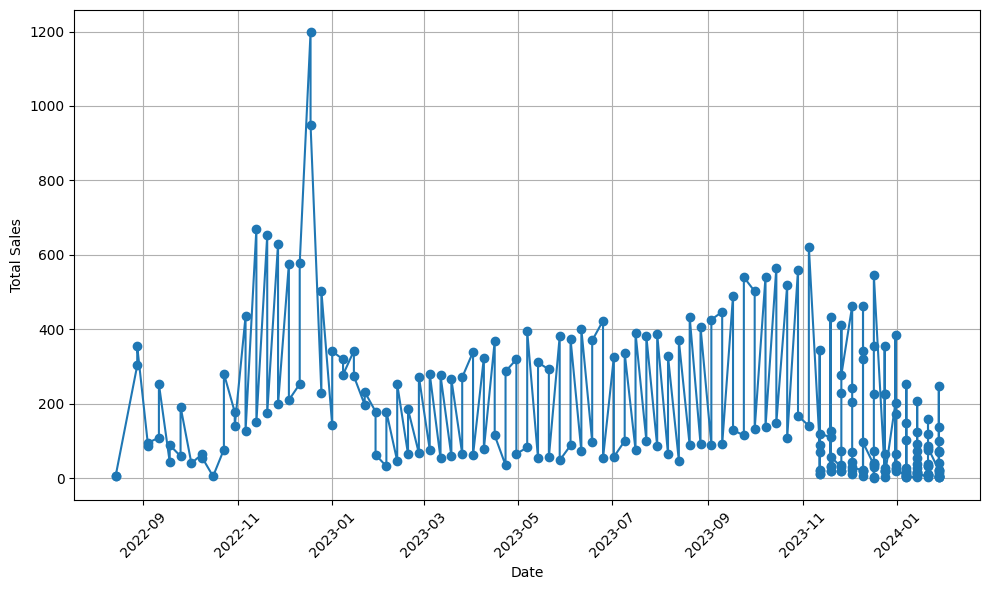

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(data_grouped['Cal Date'], data_grouped['total_quantity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'mean_forecasting' is not defined

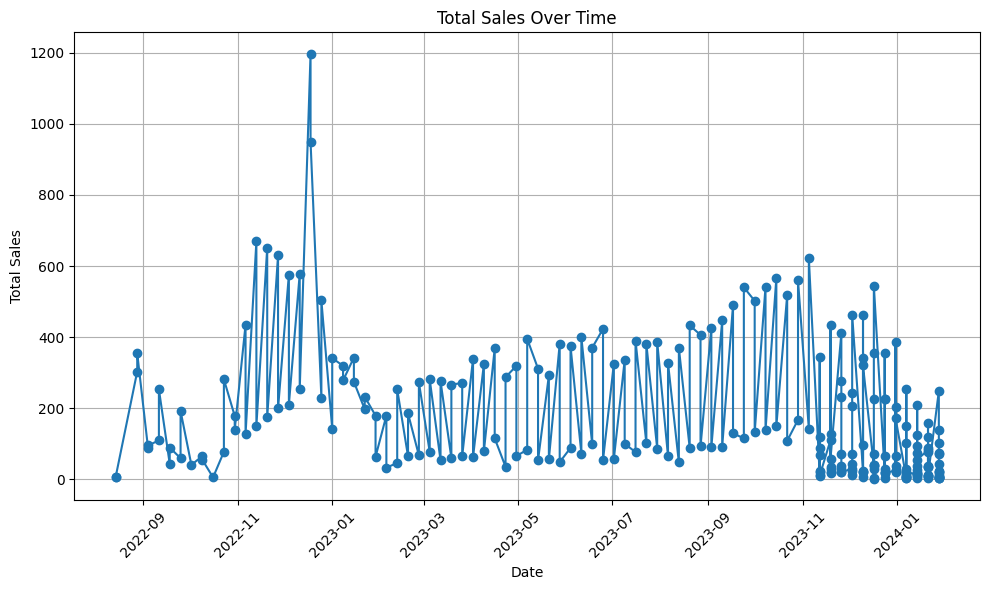

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

data = data_grouped
data = data.sort_values('Cal Date')

# Simple Moving Average (SMA)
def simple_moving_average(data, window_size=2):
    return data.rolling(window=window_size).mean().fillna(method='bfill')

# Exponential Smoothing
def exponential_smoothing(data, alpha=0.5):
    smoothed = [data.iloc[0]]
    for t in range(1, len(data)):
        smoothed.append(alpha * data.iloc[t] + (1 - alpha) * smoothed[t-1])
    return pd.Series(smoothed, index=data.index)



# Initialize empty DataFrames to store forecasts
forecast_sma = pd.DataFrame(index=data.index)
forecast_exp_smoothing = pd.DataFrame(index=data.index)

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(data['Cal Date'], data['total_quantity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Forecasting using different methods
forecast_horizon = len(data)
for model_func, model_name, linestyle, forecast_df in [
    (simple_moving_average, 'Simple Moving Average', '--',forecast_sma),
    (exponential_smoothing, 'Exponential Smoothing', '-.',forecast_exp_smoothing),
    (mean_forecasting, 'Mean Forecasting', ':',forecast_mean)
]:
    forecast = model_func(data['total_quantity'])
    plt.plot(pd.date_range(start=data['Cal Date'].iloc[-1], periods=forecast_horizon, freq='w'), forecast,
             label=model_name)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(data['total_quantity'], forecast))
    print(f"{model_name} RMSE: {rmse:.2f}")

plt.legend()
plt.show()


# Append the forecasts to the original dataset
data_with_forecasts = pd.concat([data, forecast_sma, forecast_exp_smoothing], axis=1)

# Now you can access the forecasts for each model in the data_with_forecasts DataFrame
print("Data with Forecasts:")
print(data_with_forecasts)

Simple Moving Average RMSE: 43.31
Exponential Smoothing RMSE: 35.95
Mean Forecasting RMSE: 86.81


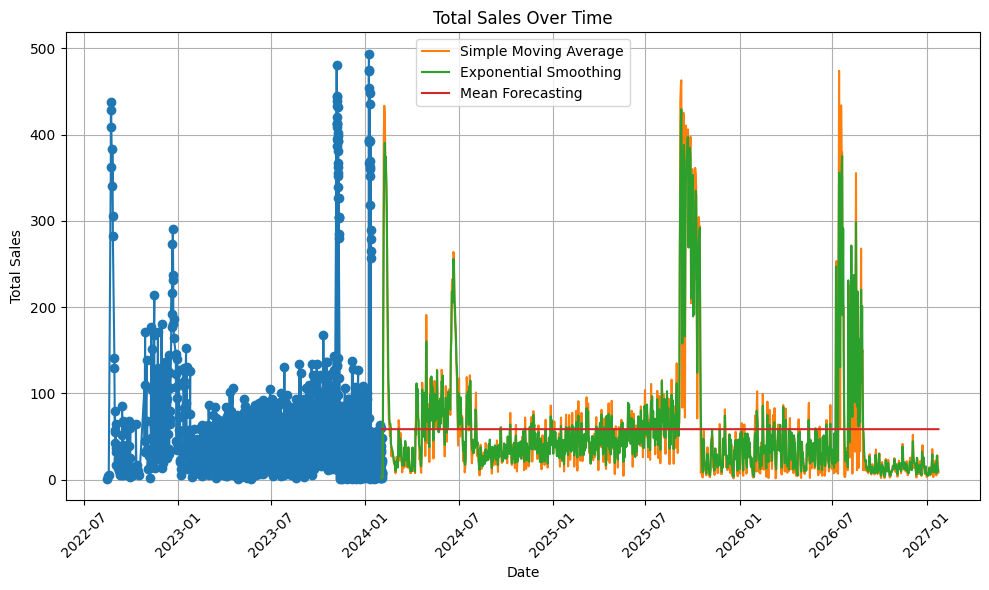

Data with Forecasts:
      unique_id Product Name   Cal Date    Brand  total_quantity  \
20           20    Product D 2022-08-15  Brand Z             1.0   
21           21    Product D 2022-08-17  Brand Z             4.0   
430         430    Product G 2022-08-18  Brand X             6.0   
431         431    Product G 2022-08-22  Brand X           363.0   
23           23    Product D 2022-08-22  Brand Z           429.0   
...         ...          ...        ...      ...             ...   
103         103    Product E 2024-02-02  Brand X             2.0   
19           19    Product A 2024-02-02  Brand Z            48.0   
646         646    Product L 2024-02-02  Brand Z             8.0   
711         711    Product Q 2024-02-02  Brand Z             9.0   
1130       1130    Product Y 2024-02-02  Brand X             7.0   

      Simple Moving Average  Exponential Smoothing  Mean Forecasting  
20                      2.5               1.000000         58.549632  
21                  

In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


data = data.sort_values('Cal Date')

# Simple Moving Average (SMA)
def simple_moving_average(data, window_size=2):
    return data.rolling(window=window_size).mean().fillna(method='bfill')

# Exponential Smoothing
def exponential_smoothing(data, alpha=0.5):
    smoothed = [data.iloc[0]]
    for t in range(1, len(data)):
        smoothed.append(alpha * data.iloc[t] + (1 - alpha) * smoothed[t-1])
    return pd.Series(smoothed, index=data.index)
# Mean Forecasting
def mean_forecasting(data):
    return pd.Series([data.mean()] * len(data), index=data.index)
    
# Initialize empty DataFrames to store forecasts
forecast_sma = pd.DataFrame(index=data.index)
forecast_exp_smoothing = pd.DataFrame(index=data.index)
forecast_mean=pd.DataFrame(index=data.index)

# Plotting the original data
plt.figure(figsize=(10, 6))
plt.plot(data['Cal Date'], data['total_quantity'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Forecasting using different methods
forecast_horizon = len(data) #
for model_func, model_name, linestyle, forecast_df in [
    (simple_moving_average, 'Simple Moving Average', '--', forecast_sma),
    (exponential_smoothing, 'Exponential Smoothing', '-.', forecast_exp_smoothing),
    (mean_forecasting, 'Mean Forecasting', ':',forecast_mean)
]:
    forecast = model_func(data['total_quantity'])
    forecast_df[model_name] = forecast
    plt.plot(pd.date_range(start=data['Cal Date'].iloc[-1], periods=forecast_horizon, freq='d'), forecast,
             label=model_name)
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(data['total_quantity'], forecast))
    print(f"{model_name} RMSE: {rmse:.2f}")

plt.legend()
plt.show()

# Append the forecasts to the original dataset
data_with_forecasts = pd.concat([data, forecast_sma, forecast_exp_smoothing,forecast_mean], axis=1)

# Now you can access the forecasts for each model in the data_with_forecasts DataFrame
print("Data with Forecasts:")
print(data_with_forecasts)


Product A, Brand Z, Simple Moving Average (Total Quantity) RMSE: 38.72
Product A, Brand Z, Simple Moving Average (Number of Stores) RMSE: 9.54
Product A, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 41.67
Product A, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 9.67
Product A, Brand Z, Mean Forecasting (Total Quantity) RMSE: 67.78
Product A, Brand Z, Mean Forecasting (Number of Stores) RMSE: 15.80


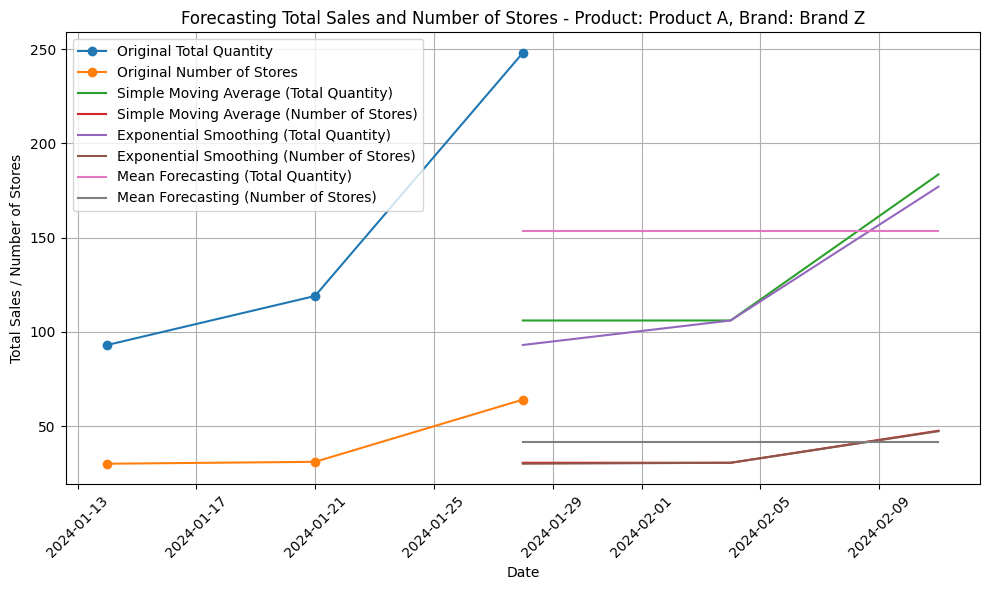

Product D, Brand Z, Simple Moving Average (Total Quantity) RMSE: 118.94
Product D, Brand Z, Simple Moving Average (Number of Stores) RMSE: 30.99
Product D, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 77.56
Product D, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 20.42
Product D, Brand Z, Mean Forecasting (Total Quantity) RMSE: 113.34
Product D, Brand Z, Mean Forecasting (Number of Stores) RMSE: 30.06


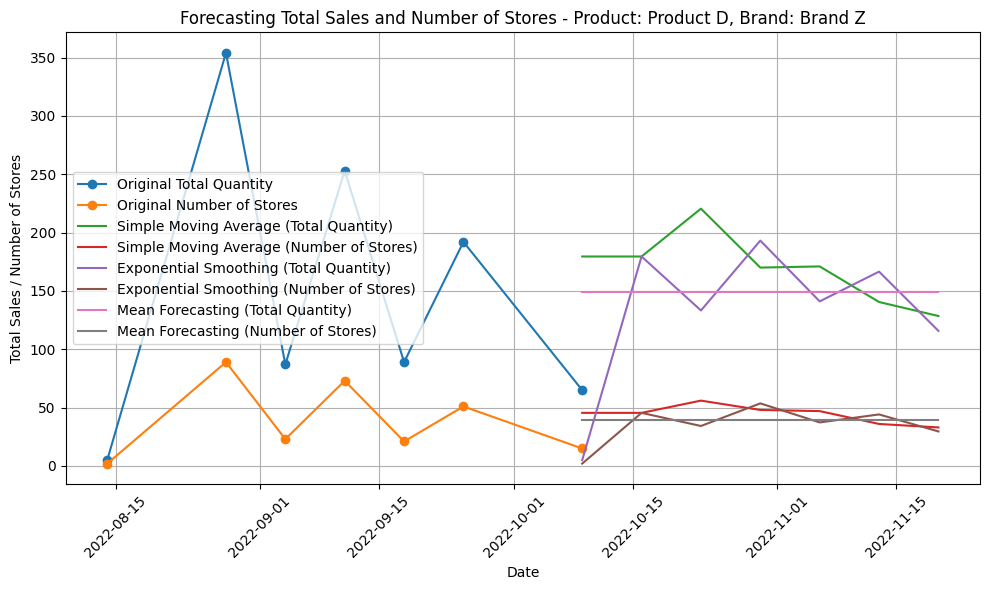

Product E, Brand X, Simple Moving Average (Total Quantity) RMSE: 8.41
Product E, Brand X, Simple Moving Average (Number of Stores) RMSE: 2.90
Product E, Brand X, Exponential Smoothing (Total Quantity) RMSE: 6.05
Product E, Brand X, Exponential Smoothing (Number of Stores) RMSE: 2.13
Product E, Brand X, Mean Forecasting (Total Quantity) RMSE: 9.55
Product E, Brand X, Mean Forecasting (Number of Stores) RMSE: 3.49


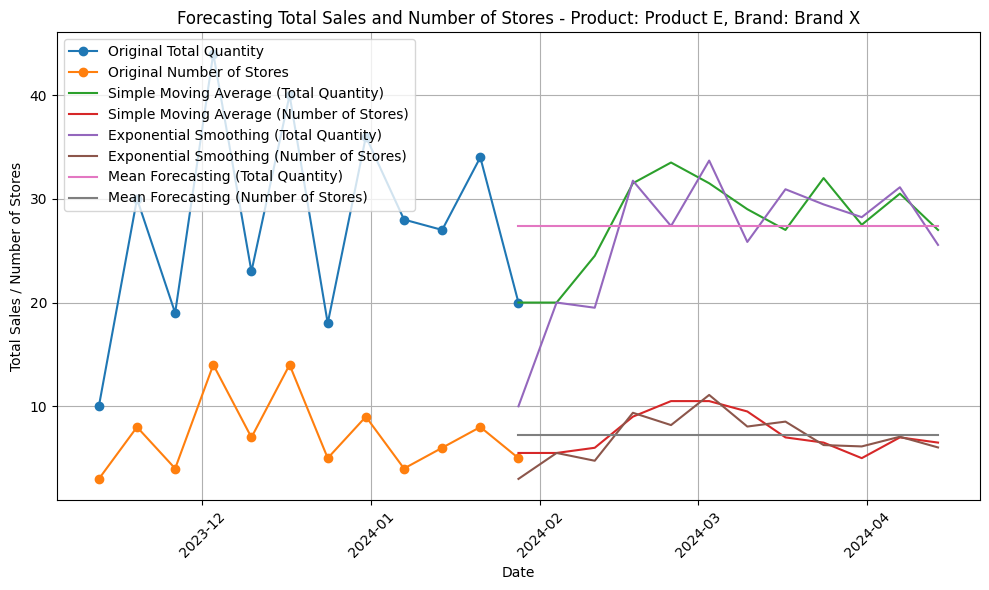

Product F, Brand X, Simple Moving Average (Total Quantity) RMSE: 65.53
Product F, Brand X, Simple Moving Average (Number of Stores) RMSE: 16.88
Product F, Brand X, Exponential Smoothing (Total Quantity) RMSE: 56.40
Product F, Brand X, Exponential Smoothing (Number of Stores) RMSE: 14.48
Product F, Brand X, Mean Forecasting (Total Quantity) RMSE: 121.37
Product F, Brand X, Mean Forecasting (Number of Stores) RMSE: 31.17


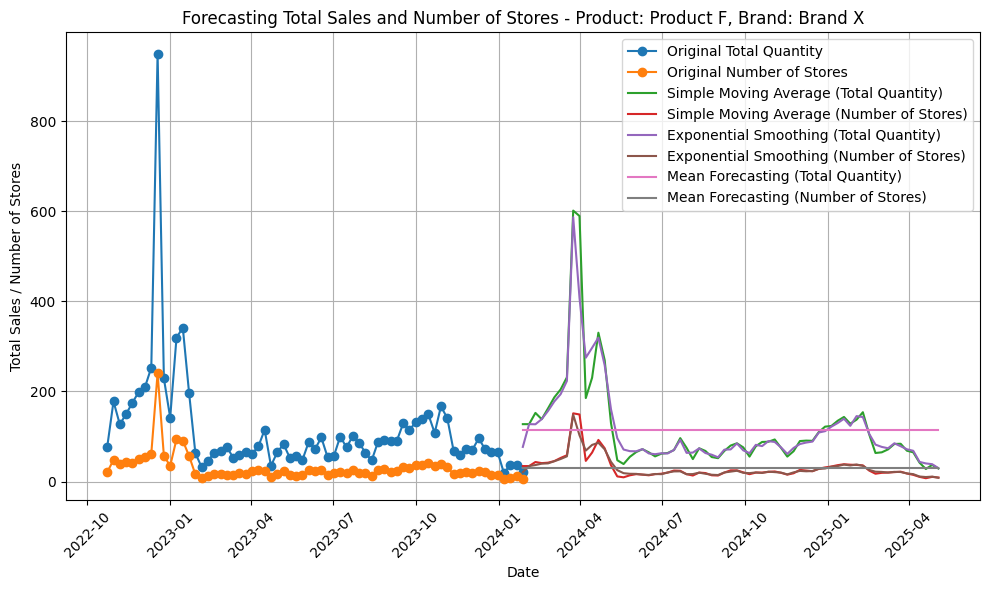

Product G, Brand X, Simple Moving Average (Total Quantity) RMSE: 79.51
Product G, Brand X, Simple Moving Average (Number of Stores) RMSE: 20.28
Product G, Brand X, Exponential Smoothing (Total Quantity) RMSE: 53.03
Product G, Brand X, Exponential Smoothing (Number of Stores) RMSE: 13.45
Product G, Brand X, Mean Forecasting (Total Quantity) RMSE: 85.59
Product G, Brand X, Mean Forecasting (Number of Stores) RMSE: 21.51


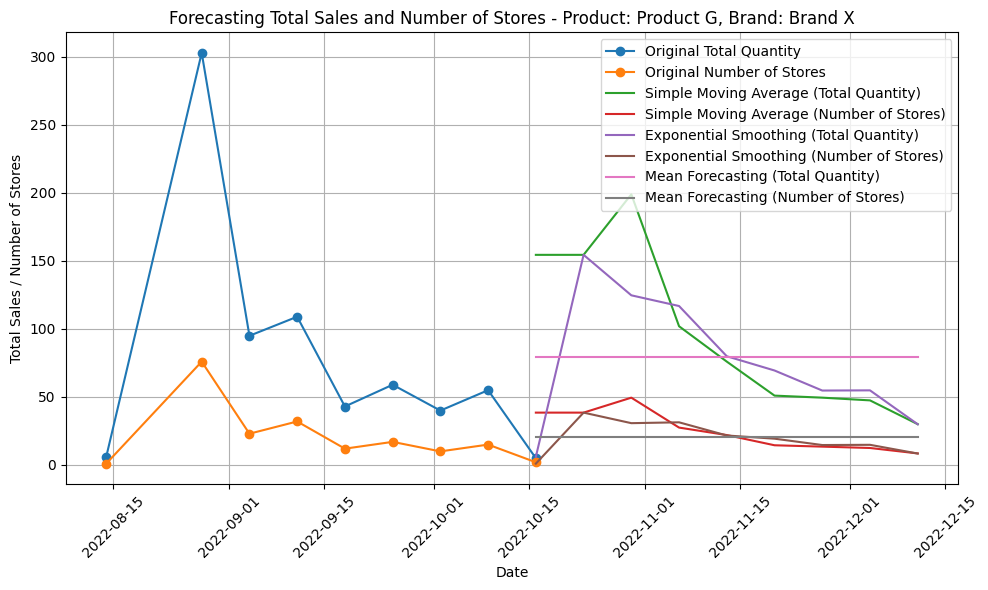

Product H, Brand X, Simple Moving Average (Total Quantity) RMSE: 6.51
Product H, Brand X, Simple Moving Average (Number of Stores) RMSE: 1.47
Product H, Brand X, Exponential Smoothing (Total Quantity) RMSE: 5.39
Product H, Brand X, Exponential Smoothing (Number of Stores) RMSE: 1.22
Product H, Brand X, Mean Forecasting (Total Quantity) RMSE: 9.51
Product H, Brand X, Mean Forecasting (Number of Stores) RMSE: 2.33


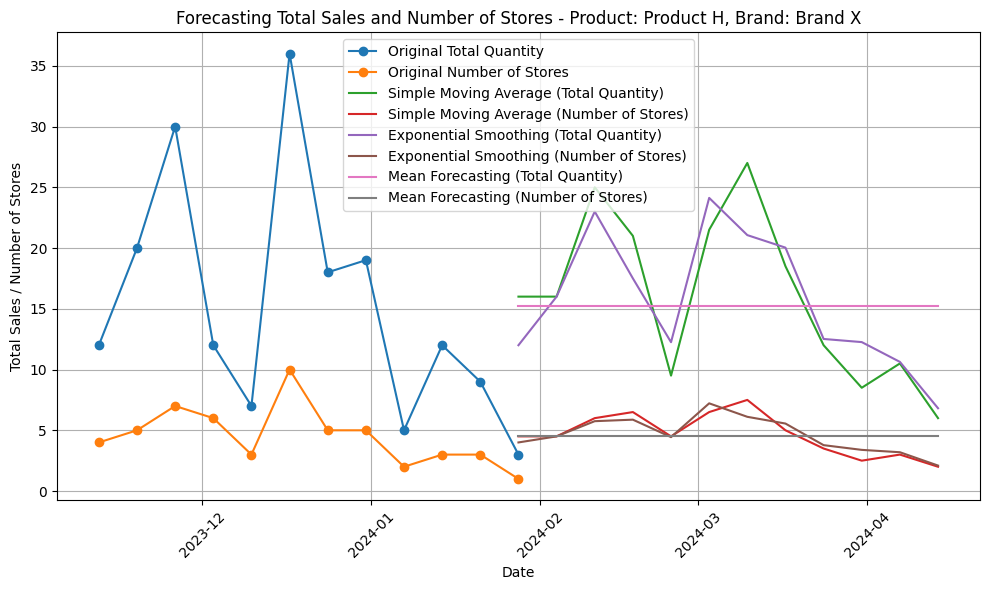

Product I, Brand X, Simple Moving Average (Total Quantity) RMSE: 0.00
Product I, Brand X, Simple Moving Average (Number of Stores) RMSE: 0.00
Product I, Brand X, Exponential Smoothing (Total Quantity) RMSE: 0.00
Product I, Brand X, Exponential Smoothing (Number of Stores) RMSE: 0.00
Product I, Brand X, Mean Forecasting (Total Quantity) RMSE: 0.00
Product I, Brand X, Mean Forecasting (Number of Stores) RMSE: 0.00


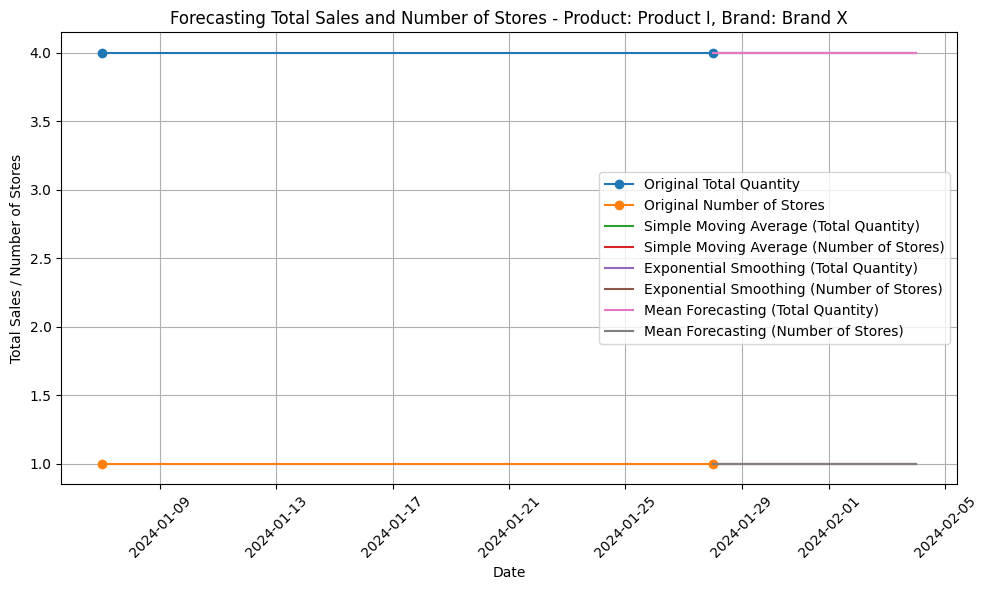

Product J, Brand X, Simple Moving Average (Total Quantity) RMSE: 6.54
Product J, Brand X, Simple Moving Average (Number of Stores) RMSE: 1.62
Product J, Brand X, Exponential Smoothing (Total Quantity) RMSE: 8.56
Product J, Brand X, Exponential Smoothing (Number of Stores) RMSE: 1.64
Product J, Brand X, Mean Forecasting (Total Quantity) RMSE: 15.35
Product J, Brand X, Mean Forecasting (Number of Stores) RMSE: 2.68


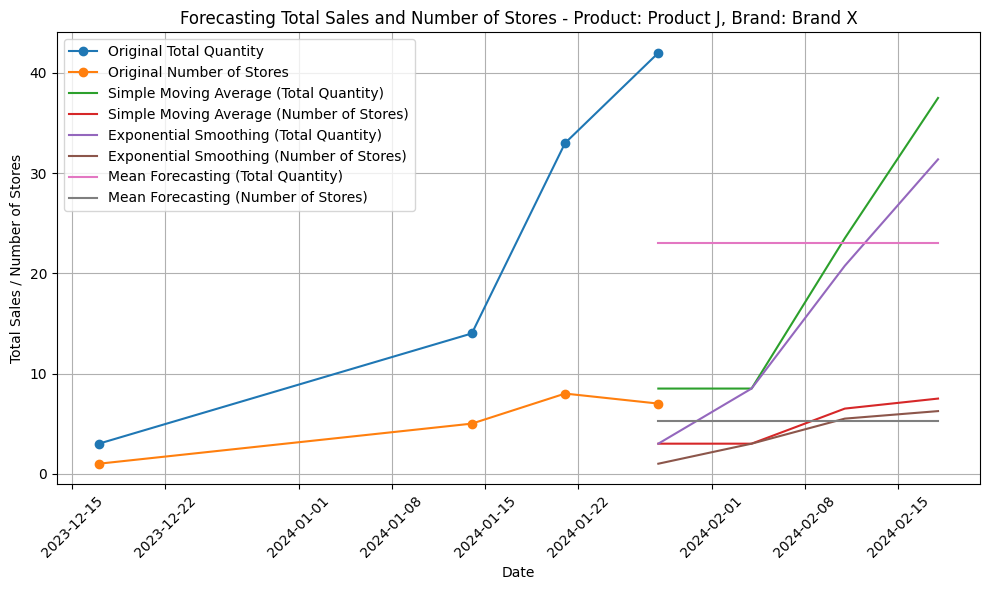

Product K, Brand X, Simple Moving Average (Total Quantity) RMSE: 4.88
Product K, Brand X, Simple Moving Average (Number of Stores) RMSE: 1.44
Product K, Brand X, Exponential Smoothing (Total Quantity) RMSE: 3.98
Product K, Brand X, Exponential Smoothing (Number of Stores) RMSE: 1.11
Product K, Brand X, Mean Forecasting (Total Quantity) RMSE: 8.84
Product K, Brand X, Mean Forecasting (Number of Stores) RMSE: 2.06


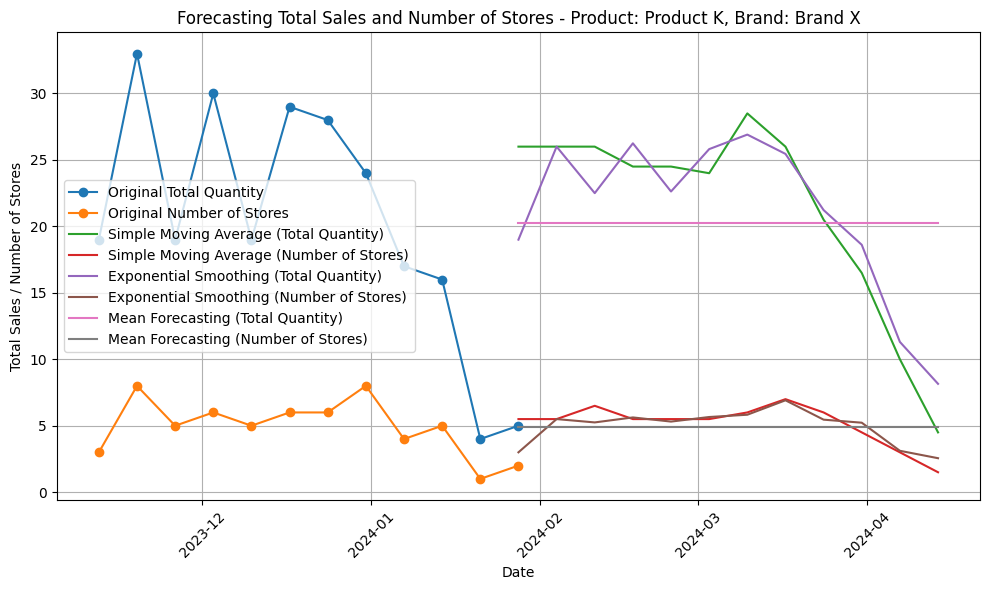

Product L, Brand Z, Simple Moving Average (Total Quantity) RMSE: 33.71
Product L, Brand Z, Simple Moving Average (Number of Stores) RMSE: 10.09
Product L, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 40.44
Product L, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 10.62
Product L, Brand Z, Mean Forecasting (Total Quantity) RMSE: 92.41
Product L, Brand Z, Mean Forecasting (Number of Stores) RMSE: 23.26


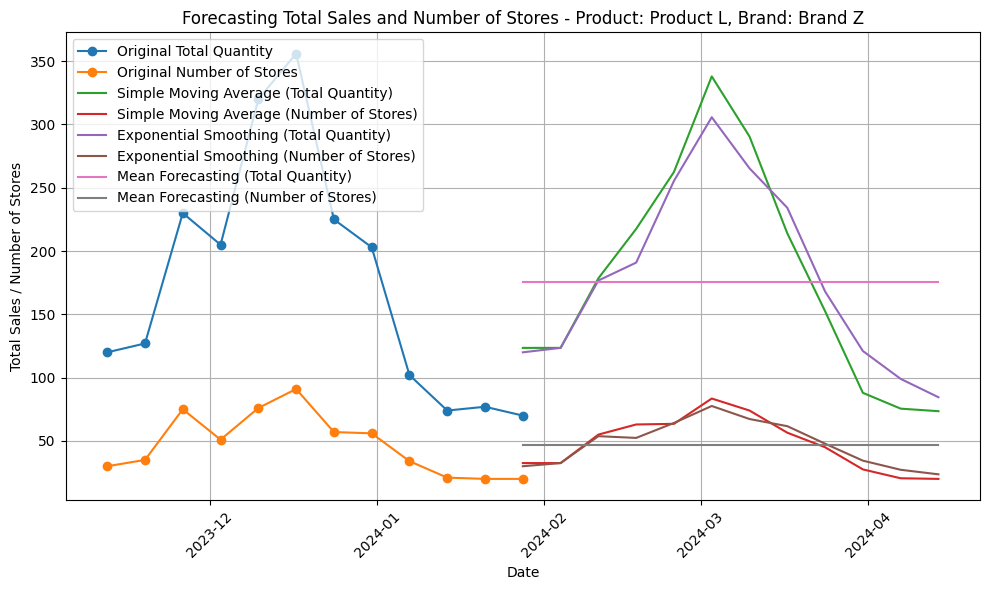

Product O, Brand X, Simple Moving Average (Total Quantity) RMSE: 3.32
Product O, Brand X, Simple Moving Average (Number of Stores) RMSE: 0.00
Product O, Brand X, Exponential Smoothing (Total Quantity) RMSE: 2.38
Product O, Brand X, Exponential Smoothing (Number of Stores) RMSE: 0.00
Product O, Brand X, Mean Forecasting (Total Quantity) RMSE: 3.40
Product O, Brand X, Mean Forecasting (Number of Stores) RMSE: 0.00


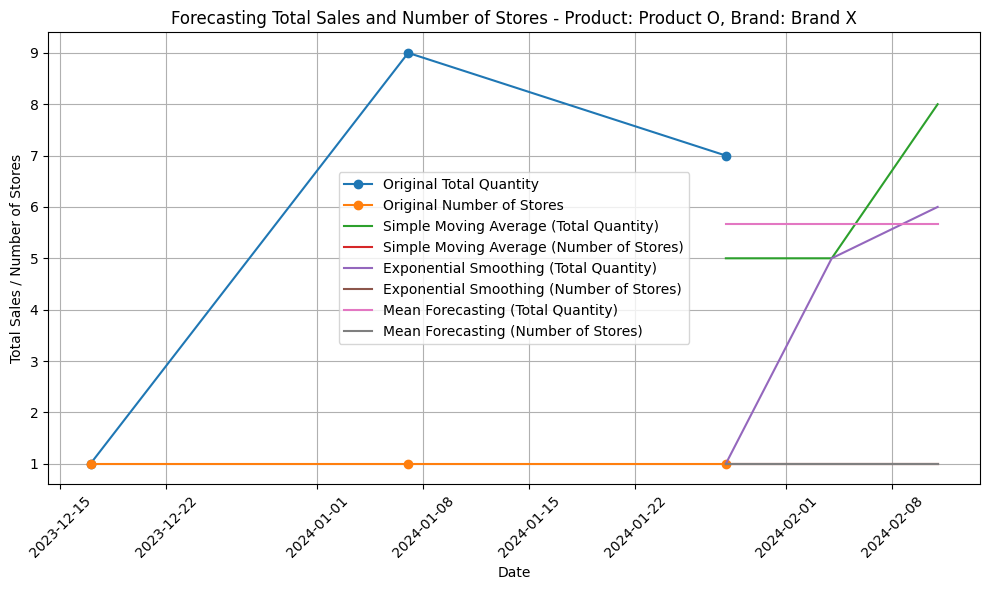

Product Q, Brand Z, Simple Moving Average (Total Quantity) RMSE: 35.01
Product Q, Brand Z, Simple Moving Average (Number of Stores) RMSE: 9.56
Product Q, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 38.46
Product Q, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 10.49
Product Q, Brand Z, Mean Forecasting (Total Quantity) RMSE: 82.00
Product Q, Brand Z, Mean Forecasting (Number of Stores) RMSE: 22.26


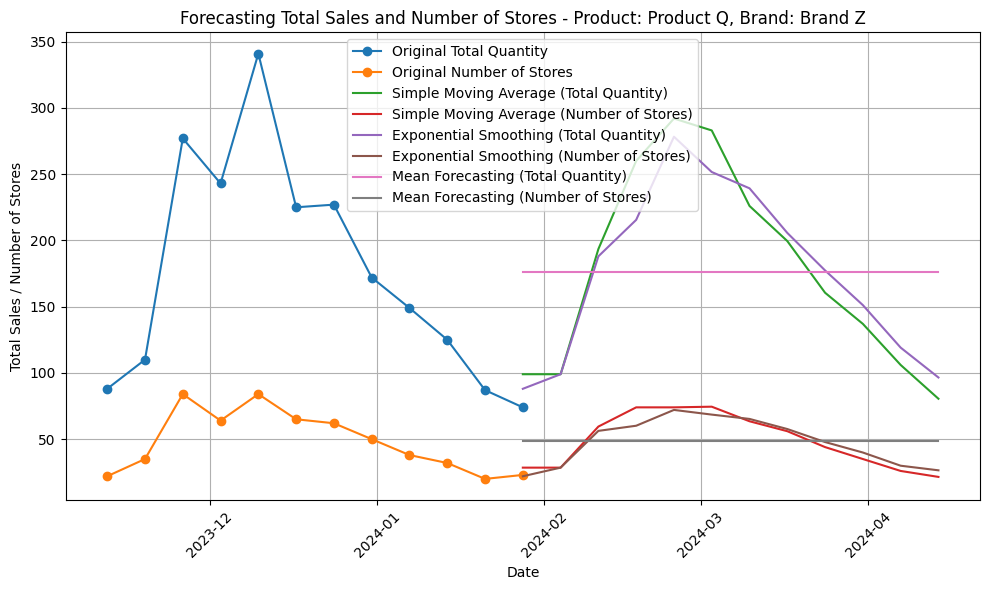

Product R, Brand Z, Simple Moving Average (Total Quantity) RMSE: 24.07
Product R, Brand Z, Simple Moving Average (Number of Stores) RMSE: 5.76
Product R, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 27.75
Product R, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 7.32
Product R, Brand Z, Mean Forecasting (Total Quantity) RMSE: 48.69
Product R, Brand Z, Mean Forecasting (Number of Stores) RMSE: 13.08


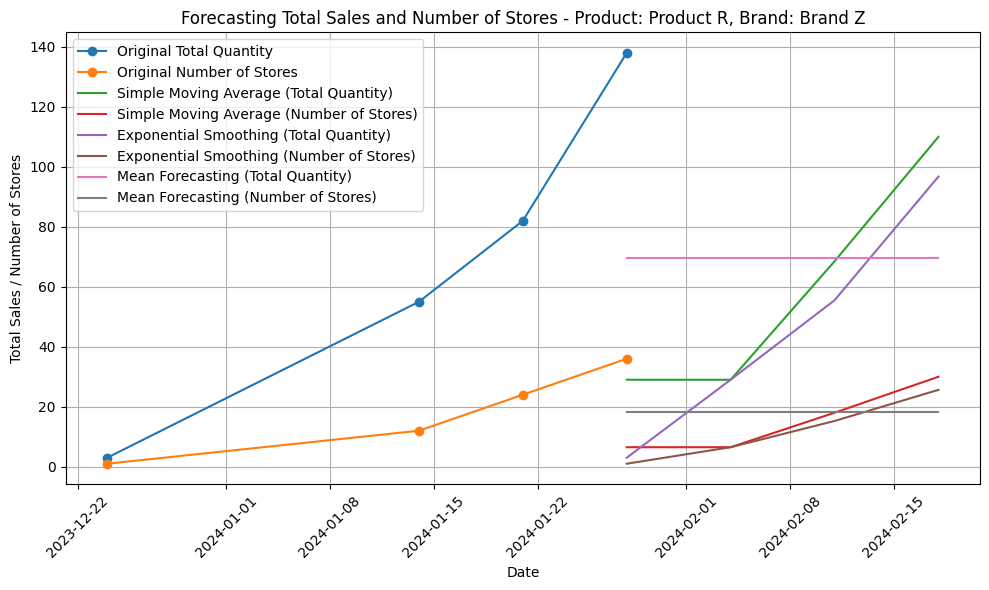

Product S, Brand Z, Simple Moving Average (Total Quantity) RMSE: 70.81
Product S, Brand Z, Simple Moving Average (Number of Stores) RMSE: 18.35
Product S, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 67.12
Product S, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 17.53
Product S, Brand Z, Mean Forecasting (Total Quantity) RMSE: 162.75
Product S, Brand Z, Mean Forecasting (Number of Stores) RMSE: 43.01


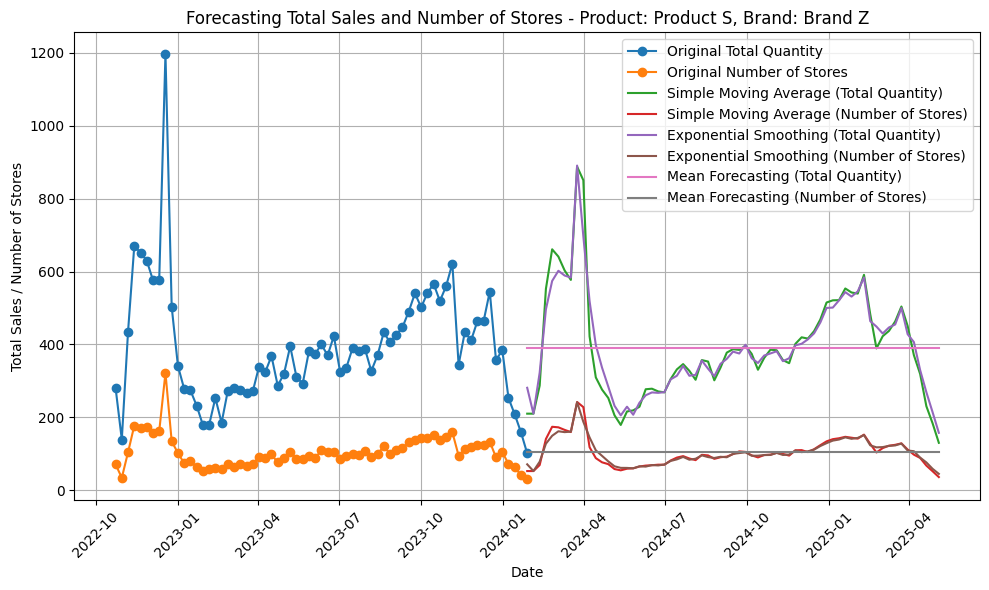

Product T, Brand X, Simple Moving Average (Total Quantity) RMSE: 6.00
Product T, Brand X, Simple Moving Average (Number of Stores) RMSE: 1.39
Product T, Brand X, Exponential Smoothing (Total Quantity) RMSE: 4.62
Product T, Brand X, Exponential Smoothing (Number of Stores) RMSE: 1.07
Product T, Brand X, Mean Forecasting (Total Quantity) RMSE: 8.70
Product T, Brand X, Mean Forecasting (Number of Stores) RMSE: 2.10


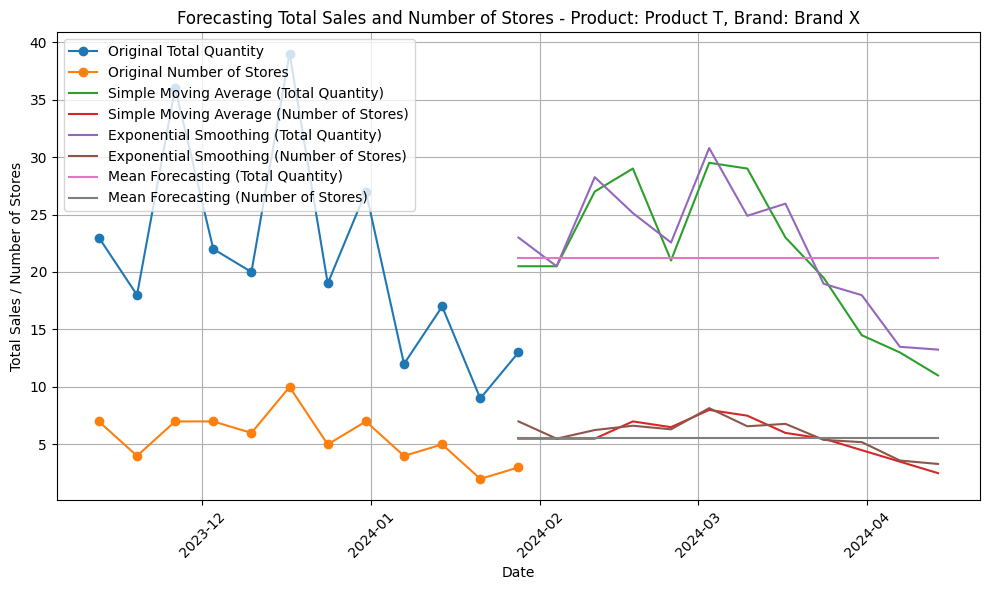

Product U, Brand X, Simple Moving Average (Total Quantity) RMSE: 0.00
Product U, Brand X, Simple Moving Average (Number of Stores) RMSE: 0.00
Product U, Brand X, Exponential Smoothing (Total Quantity) RMSE: 0.00
Product U, Brand X, Exponential Smoothing (Number of Stores) RMSE: 0.00
Product U, Brand X, Mean Forecasting (Total Quantity) RMSE: 0.00
Product U, Brand X, Mean Forecasting (Number of Stores) RMSE: 0.00


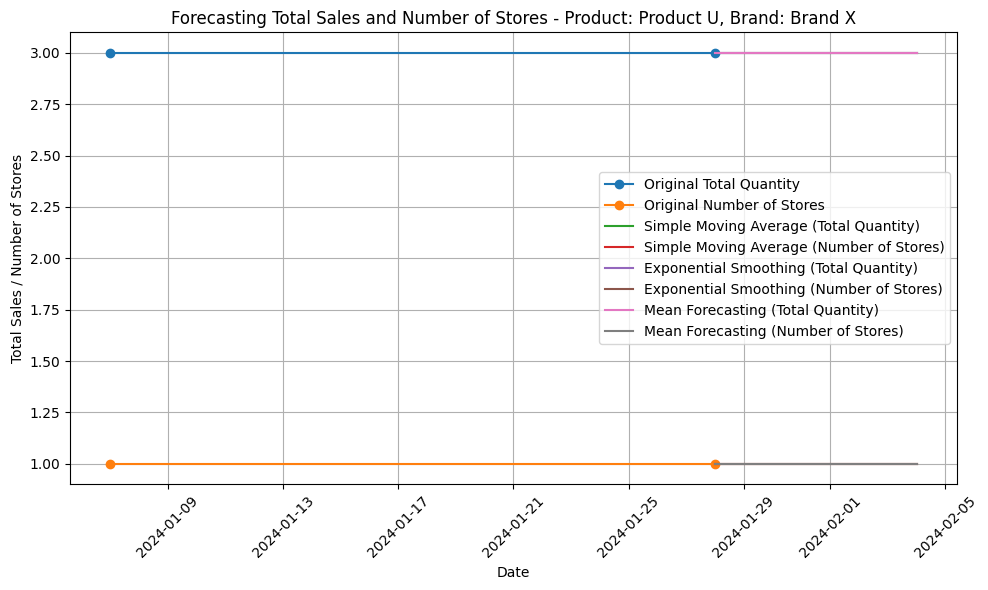

Product W, Brand Z, Simple Moving Average (Total Quantity) RMSE: 2.28
Product W, Brand Z, Simple Moving Average (Number of Stores) RMSE: 0.75
Product W, Brand Z, Exponential Smoothing (Total Quantity) RMSE: 1.60
Product W, Brand Z, Exponential Smoothing (Number of Stores) RMSE: 0.50
Product W, Brand Z, Mean Forecasting (Total Quantity) RMSE: 2.49
Product W, Brand Z, Mean Forecasting (Number of Stores) RMSE: 0.71


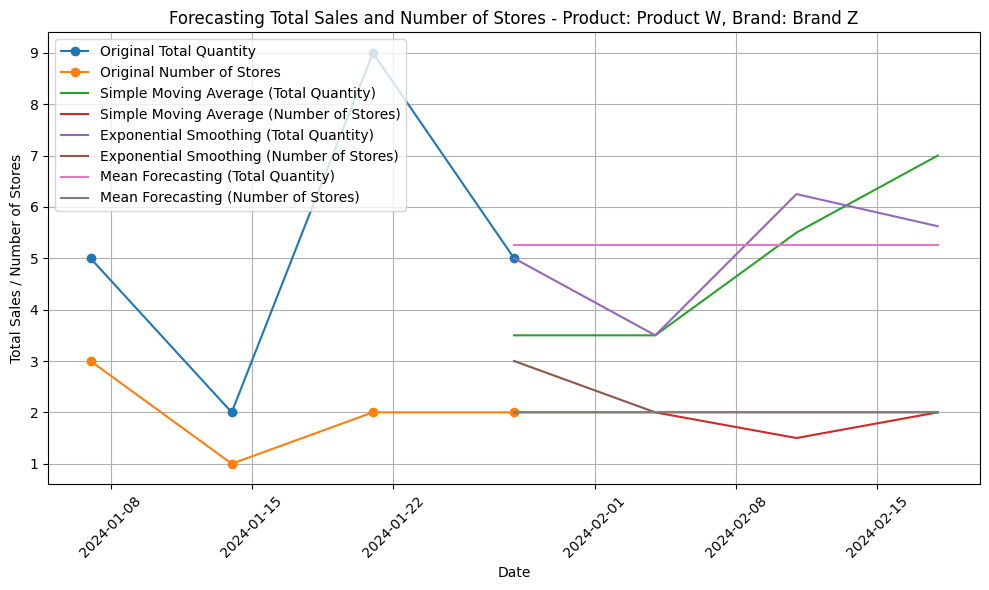

Product Y, Brand X, Simple Moving Average (Total Quantity) RMSE: 3.14
Product Y, Brand X, Simple Moving Average (Number of Stores) RMSE: 1.19
Product Y, Brand X, Exponential Smoothing (Total Quantity) RMSE: 3.43
Product Y, Brand X, Exponential Smoothing (Number of Stores) RMSE: 0.82
Product Y, Brand X, Mean Forecasting (Total Quantity) RMSE: 5.56
Product Y, Brand X, Mean Forecasting (Number of Stores) RMSE: 1.25


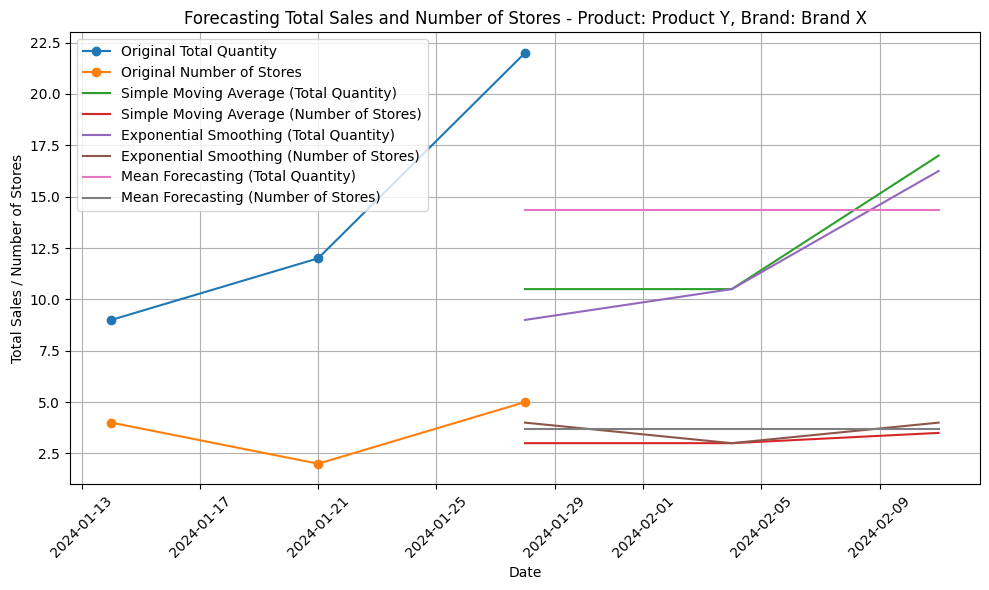

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Assuming your dataset is named 'data' and has columns 'Cal Date', 'total_quantity', 'product', and 'brand'
# Replace these column names with your actual column names

# Sort the data by 'Cal Date'
data = data.sort_values('Cal Date')

# Define forecasting models (you can add more models if needed)
def simple_moving_average(data, window_size=2):
    return data.rolling(window=window_size).mean().fillna(method='bfill')

def exponential_smoothing(data, alpha=0.5):
    smoothed = [data.iloc[0]]
    for t in range(1, len(data)):
        smoothed.append(alpha * data.iloc[t] + (1 - alpha) * smoothed[t-1])
    return pd.Series(smoothed, index=data.index)
    
# Mean Forecasting
def mean_forecasting(data):
    return pd.Series([data.mean()] * len(data), index=data.index)
    
# Initialize empty DataFrames to store forecasts
forecast_sma = pd.DataFrame(index=data.index)
forecast_exp_smoothing = pd.DataFrame(index=data.index)
forecast_mean=pd.DataFrame(index=data.index)
# Group the data by 'product' and 'brand'
grouped_data = data.groupby(['Product Name', 'Brand'])
# Initialize empty DataFrames to store forecasts
forecast_data_sma = pd.DataFrame()
forecast_data_exp_smoothing = pd.DataFrame()
for (product, brand), group_df in grouped_data:
    # Forecasting using different methods for the current group
    forecast_horizon = len(group_df)
    future_dates = pd.date_range(start=group_df['Cal Date'].iloc[-1], periods=forecast_horizon, freq='W')

    plt.figure(figsize=(10, 6))
    plt.plot(group_df['Cal Date'], group_df['total_quantity'], marker='o', linestyle='-', label='Original Total Quantity')
    plt.plot(group_df['Cal Date'], group_df['number_of_stores'], marker='o', linestyle='-', label='Original Number of Stores')
    
    for model_func, model_name in [
        (simple_moving_average, 'Simple Moving Average'),
        (exponential_smoothing, 'Exponential Smoothing'),
        (mean_forecasting, 'Mean Forecasting')
    ]:
        forecast_quantity = model_func(group_df['total_quantity'])
        forecast_stores = model_func(group_df['number_of_stores'])
        
        plt.plot(future_dates, forecast_quantity, label=f'{model_name} (Total Quantity)')
        plt.plot(future_dates, forecast_stores, label=f'{model_name} (Number of Stores)')
        
        # Calculate RMSE for the current model (Total Quantity)
        rmse_quantity = np.sqrt(mean_squared_error(group_df['total_quantity'], forecast_quantity[:len(group_df)]))
        print(f"{product}, {brand}, {model_name} (Total Quantity) RMSE: {rmse_quantity:.2f}")
        
        # Calculate RMSE for the current model (Number of Stores)
        rmse_stores = np.sqrt(mean_squared_error(group_df['number_of_stores'], forecast_stores[:len(group_df)]))
        print(f"{product}, {brand}, {model_name} (Number of Stores) RMSE: {rmse_stores:.2f}")

    plt.xlabel('Date')
    plt.ylabel('Total Sales / Number of Stores')
    plt.title(f'Forecasting Total Sales and Number of Stores - Product: {product}, Brand: {brand}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend()
    plt.show()

In [17]:
data_grouped.sort_values('unique_id')

,unique_id,Product Name,Cal Date,Brand,total_quantity,number_of_stores
1,1,Product A,2024-01-14,Brand Z,93.0,30
2,2,Product A,2024-01-21,Brand Z,119.0,31
3,3,Product A,2024-01-28,Brand Z,248.0,64
4,4,Product D,2022-08-14,Brand Z,5.0,2
6,6,Product D,2022-08-28,Brand Z,354.0,89
...,...,...,...,...,...,...
253,253,Product W,2024-01-21,Brand Z,9.0,2
254,254,Product W,2024-01-28,Brand Z,5.0,2
256,256,Product Y,2024-01-14,Brand X,9.0,4
257,257,Product Y,2024-01-21,Brand X,12.0,2


In [23]:
# Create an empty list to store forecasted data
forecasted_data = []

# Loop through each group and apply the forecasting models
for (product, brand), group_df in grouped_data:
    # Forecasting using different methods for the current group
    forecast_horizon = len(group_df)
    future_dates = pd.date_range(start=group_df['Cal Date'].iloc[-1], periods=forecast_horizon, freq='w')
    
    # Initialize a dictionary to store forecasted data for the current product and brand
    product_forecast = {
        'Product': [product] * forecast_horizon,
        'Brand': [brand] * forecast_horizon,
        'Date': future_dates
    }
    
    for model_func, model_name in [
        (simple_moving_average, 'Simple Moving Average'),
        (exponential_smoothing, 'Exponential Smoothing'),
        (mean_forecasting, 'Mean Forecasting')
    ]:
        # Forecast total quantity
        forecast_quantity = model_func(group_df['total_quantity'])
        product_forecast[f'{model_name} Total Quantity'] = forecast_quantity.values.tolist()
        
        # Forecast number of stores
        forecast_stores = model_func(group_df['number_of_stores'])
        product_forecast[f'{model_name} Number of Stores'] = forecast_stores.values.tolist()
    
    # Append the forecasted data for the current product and brand to the main list
    forecasted_data.append(pd.DataFrame(product_forecast))

# Concatenate all forecasted dataframes into a single dataframe
forecasted_data = pd.concat(forecasted_data, ignore_index=True)

# Save the forecasted data to a CSV file
forecasted_data.to_csv('forecasted_data.csv', index=False)

# Print the forecasted data
print("Forecasted Data:")
print(forecasted_data)


Forecasted Data:
       Product    Brand       Date  Simple Moving Average Total Quantity  \
0    Product A  Brand Z 2024-01-28                                 106.0   
1    Product A  Brand Z 2024-02-04                                 106.0   
2    Product A  Brand Z 2024-02-11                                 183.5   
3    Product D  Brand Z 2022-10-09                                 179.5   
4    Product D  Brand Z 2022-10-16                                 179.5   
..         ...      ...        ...                                   ...   
242  Product W  Brand Z 2024-02-11                                   5.5   
243  Product W  Brand Z 2024-02-18                                   7.0   
244  Product Y  Brand X 2024-01-28                                  10.5   
245  Product Y  Brand X 2024-02-04                                  10.5   
246  Product Y  Brand X 2024-02-11                                  17.0   

     Simple Moving Average Number of Stores  \
0                      

In [24]:
forecasted_data.sort_values('Date')

,Product,Brand,Date,Simple Moving Average Total Quantity,Simple Moving Average Number of Stores,Exponential Smoothing Total Quantity,Exponential Smoothing Number of Stores,Mean Forecasting Total Quantity,Mean Forecasting Number of Stores
3,Product D,Brand Z,2022-10-09,179.5,45.5,5.000000,2.000000,149.285714,39.142857
89,Product G,Brand X,2022-10-16,154.5,38.5,6.000000,1.000000,79.444444,20.888889
4,Product D,Brand Z,2022-10-16,179.5,45.5,179.500000,45.500000,149.285714,39.142857
5,Product D,Brand Z,2022-10-23,220.5,56.0,133.250000,34.250000,149.285714,39.142857
90,Product G,Brand X,2022-10-23,154.5,38.5,154.500000,38.500000,79.444444,20.888889
...,...,...,...,...,...,...,...,...,...
223,Product S,Brand Z,2025-04-20,230.5,67.5,268.867006,76.244386,391.388060,104.447761
87,Product F,Brand X,2025-04-27,37.0,10.5,38.671966,11.072251,113.940299,30.104478
224,Product S,Brand Z,2025-04-27,183.5,52.0,213.933503,58.622193,391.388060,104.447761
88,Product F,Brand X,2025-05-04,29.0,9.0,29.835983,8.536126,113.940299,30.104478
